In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install statsmodels
import statsmodels.api as sm
!pip install scikit-learn
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression


[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
data = pd.read_csv("../data/output/master_data.csv")
df = pd.read_csv("../data/output/master_data.csv")

/tmp/ipykernel_2396596/1682891055.py:1: DtypeWarning: Columns (23,24,41,42,44,61) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/output/master_data.csv")
/tmp/ipykernel_2396596/1682891055.py:2: DtypeWarning: Columns (23,24,41,42,44,61) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/output/master_data.csv")


In [4]:
print (df.head())

  contractid  planid     fips  year  n_nonmiss  avg_enrollment  sd_enrollment  \
0      H0028     1.0  19103.0  2014          2           238.0       2.828427   
1      H0028     1.0  19113.0  2014          2          1334.5       4.949747   
2      H0028     2.0  19153.0  2014          2           347.0       1.414214   
3      H0028     3.0  19155.0  2014          2           173.0      11.313708   
4      H0028     4.0  15003.0  2014          2          1019.5      20.506097   

   min_enrollment  max_enrollment  first_enrollment  ...  rebate_partc  \
0           236.0           240.0             240.0  ...           NaN   
1          1331.0          1338.0            1338.0  ...           NaN   
2           346.0           348.0             346.0  ...         49.83   
3           165.0           181.0             165.0  ...         30.69   
4          1005.0          1034.0            1034.0  ...         48.97   

  year_reb payment_partd directsubsidy_partd reinsurance_partd  \
0 

In [5]:
summary_df = data.describe()
print(summary_df)

             planid           fips           year      n_nonmiss  \
count  348336.00000  348336.000000  348336.000000  348336.000000   
mean       37.88530   29480.029050    2016.743435       0.924076   
std        67.74584   15608.198231       1.736773       0.995085   
min         1.00000    1001.000000    2014.000000       0.000000   
25%         4.00000   17001.000000    2015.000000       0.000000   
50%        17.00000   29079.000000    2017.000000       0.000000   
75%        49.00000   42081.000000    2018.000000       2.000000   
max       999.00000   56045.000000    2019.000000       4.000000   

       avg_enrollment  sd_enrollment  min_enrollment  max_enrollment  \
count   162365.000000  159046.000000   162365.000000   162365.000000   
mean       478.689529      20.854759      462.455517      495.114674   
std       1836.351888     627.300176     1743.789962     2071.754248   
min         11.000000       0.000000       11.000000       11.000000   
25%         31.000000      

In [6]:
columns_df = pd.DataFrame(data.columns, columns=['column_name'])
print(columns_df)

          column_name
0          contractid
1              planid
2                fips
3                year
4           n_nonmiss
..                ...
57  costsharing_partd
58    riskscore_partd
59      basic_premium
60                bid
61        contract_id

[62 rows x 1 columns]


/tmp/ipykernel_2396596/1398979315.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_year, labels=[str(int(y)) for y in years])


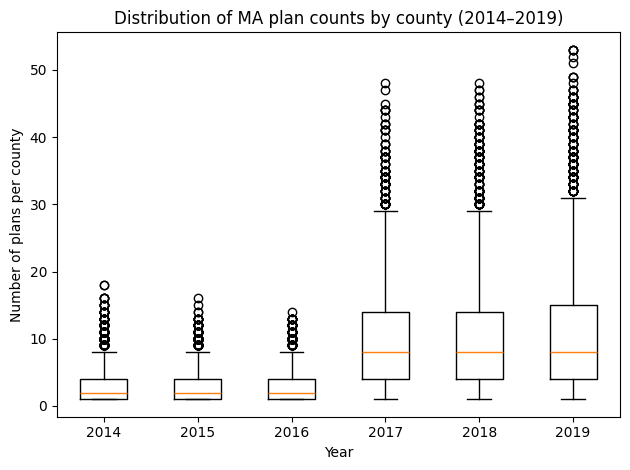

   year  count  median       mean  min  max
0  2014   2946     2.0   3.465716    1   18
1  2015   2916     2.0   3.199931    1   16
2  2016   2903     2.0   3.137788    1   14
3  2017   2965     8.0  10.183811    1   48
4  2018   3002     8.0  10.585610    1   48
5  2019   3026     8.0  10.793126    1   53


In [7]:
# Question 1
data["planid_num"] = pd.to_numeric(data["planid"], errors="coerce")
data["year"] = pd.to_numeric(data["year"], errors="coerce")

# --- 1. Apply assignment filters ---

# Remove SNPs
data = data[data["snp"] != "Yes"]

# Remove 800-series plans
data = data[~data["planid_num"].between(800, 899, inclusive="both")]

# Remove prescription-drug-only plans
# PDPs typically have Part D but no Part C premium
data = data[~((data["partd"] == "Yes") & (data["premium_partc"].isna()))]

# Keep valid counties and years
data["fips"] = pd.to_numeric(data["fips"], errors="coerce")
data = data[data["fips"].notna()]
data = data[data["year"].between(2014, 2019)]

# --- 2. Count plans per county-year ---
data["plan_key"] = data["contractid"].astype(str) + "-" + data["planid_num"].astype("Int64").astype(str)

plan_counts = (
    data.groupby(["year", "fips"])["plan_key"]
      .nunique()
      .reset_index(name="n_plans")
)

# --- 3. Boxplot by year ---
years = sorted(plan_counts["year"].unique())
data_by_year = [
    plan_counts.loc[plan_counts["year"] == y, "n_plans"].values
    for y in years
]

plt.figure()
plt.boxplot(data_by_year, labels=[str(int(y)) for y in years])
plt.xlabel("Year")
plt.ylabel("Number of plans per county")
plt.title("Distribution of MA plan counts by county (2014–2019)")
plt.tight_layout()
plt.show()

# --- 4. Summary stats for interpretation ---
summary = (
    plan_counts.groupby("year")["n_plans"]
    .agg(["count", "median", "mean", "min", "max"])
    .reset_index()
)

print(summary)

In [ ]:
# Do you think that the number of plans is sufficient, too few, or too many? 
Between 2014-2016, the number of plans was too few. Between 2017-2019, the number of plans was much higher, in my opinion at a 
sufficient value. Overall, the graph shows expanding plan availability over time. 

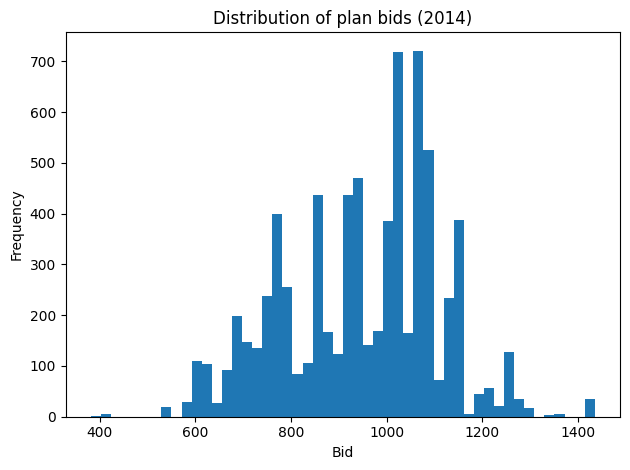

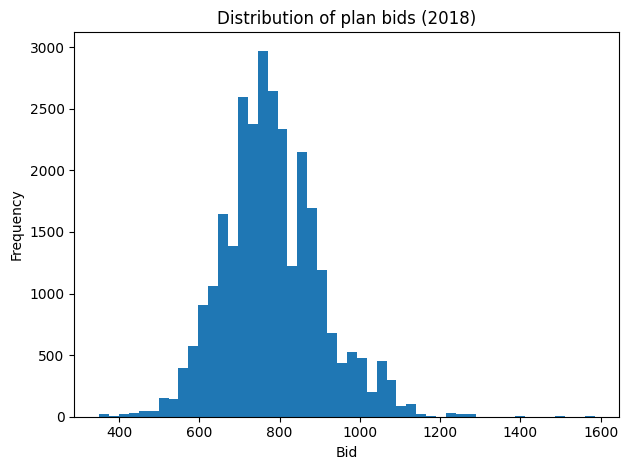

            n        mean      median         p10          p90         min  \
2014   7454.0  949.405301  970.673155  720.526316  1137.057992  381.252408   
2018  29008.0  781.560874  770.841367  637.091238   939.047059  350.218023   

              max  
2014  1435.787402  
2018  1584.731405  


In [8]:
# Question 2


for c in ["rebate_partc", "premium", "premium_partc", "payment_partc", "riskscore_partc", "bid"]:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c], errors="coerce")

# compute basic premium + bid 
data["basic_premium_recalc"] = np.where(
    data["rebate_partc"] > 0,
    0,
    np.where(
        (data["partd"] == "No") & data["premium"].notna() & data["premium_partc"].isna(),
        data["premium"],
        data["premium_partc"]
    )
)

# bid:
data["bid_recalc"] = np.nan
valid_risk = data["riskscore_partc"].notna() & (data["riskscore_partc"] != 0)

mask1 = valid_risk & (data["rebate_partc"] == 0) & (data["basic_premium_recalc"] > 0)
data.loc[mask1, "bid_recalc"] = (
    (data.loc[mask1, "payment_partc"] + data.loc[mask1, "basic_premium_recalc"])
    / data.loc[mask1, "riskscore_partc"]
)

mask2 = valid_risk & ((data["rebate_partc"] > 0) | (data["basic_premium_recalc"] == 0))
data.loc[mask2, "bid_recalc"] = (
    data.loc[mask2, "payment_partc"] / data.loc[mask2, "riskscore_partc"]
)

#Frequency histograms: 2014 vs 2018
def plot_bid_hist(df, year, bid_col="bid_recalc", bins=50):
    x = df.loc[df["year"] == year, bid_col].dropna()
    plt.figure()
    plt.hist(x, bins=bins)
    plt.title(f"Distribution of plan bids ({year})")
    plt.xlabel("Bid")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_bid_hist(data, 2014, bid_col="bid_recalc", bins=50)
plot_bid_hist(data, 2018, bid_col="bid_recalc", bins=50)

#summary stats
def bid_summary(df, year, bid_col="bid_recalc"):
    x = df.loc[df["year"] == year, bid_col].dropna()
    return pd.Series({
        "n": x.shape[0],
        "mean": x.mean(),
        "median": x.median(),
        "p10": x.quantile(0.10),
        "p90": x.quantile(0.90),
        "min": x.min(),
        "max": x.max(),
    })

bid_stats = pd.DataFrame(
    [bid_summary(data, 2014), bid_summary(data, 2018)],
    index=[2014, 2018]
)
print(bid_stats)

In [ ]:
# How has distribution changed over time
The distribution of these plan bids shifted downward on average, while the overall number of plans increased. 

   year   avg_hhi
0  2014  0.755467
1  2015  0.773888
2  2016  0.778841
3  2017  0.493490
4  2018  0.492771
5  2019  0.489980


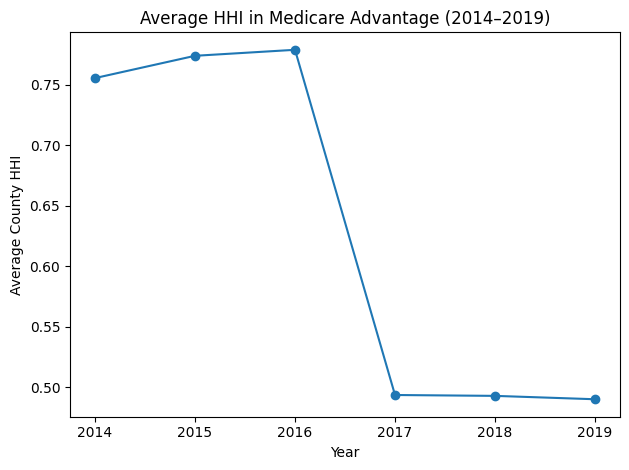

In [9]:
# Question 3

# numeric enrollment
data["avg_enrollment"] = pd.to_numeric(data["avg_enrollment"], errors="coerce")

# Keep only relevant years and valid enrollment
hhi_data = data[
    data["year"].between(2014, 2019) &
    data["avg_enrollment"].notna()
].copy()

# Compute contract-level enrollment per county-year
contract_enrollment = (
    hhi_data.groupby(["year", "fips", "contractid"])["avg_enrollment"]
    .sum()
    .reset_index(name="contract_enroll")
)

# Compute total county enrollment
county_totals = (
    contract_enrollment.groupby(["year", "fips"])["contract_enroll"]
    .sum()
    .reset_index(name="county_total")
)

contract_enrollment = contract_enrollment.merge(
    county_totals,
    on=["year", "fips"],
    how="left"
)

# Compute market shares and HHI
contract_enrollment["share"] = (
    contract_enrollment["contract_enroll"]
    / contract_enrollment["county_total"]
)

contract_enrollment["share_sq"] = contract_enrollment["share"] ** 2

county_hhi = (
    contract_enrollment.groupby(["year", "fips"])["share_sq"]
    .sum()
    .reset_index(name="hhi")
)

# Average HHI by year
avg_hhi = (
    county_hhi.groupby("year")["hhi"]
    .mean()
    .reset_index(name="avg_hhi")
)

print(avg_hhi)

# Plot
plt.figure()
plt.plot(avg_hhi["year"], avg_hhi["avg_hhi"], marker="o")
plt.xlabel("Year")
plt.ylabel("Average County HHI")
plt.title("Average HHI in Medicare Advantage (2014–2019)")
plt.tight_layout()
plt.show()

In [ ]:
# How has the HHI changed over time 
From 2014-2016, HHI was very high, indicating that MA markets were highly concentrated during these years. However, beginning in 2017,
the average HHI dropped sharply and continued a downward trend, indicating that MA markets became more competitive over time and had 
lower market concentration. 

   year  avg_ma_share
0  2017      0.247862
1  2018      0.254951
2  2019      0.282956


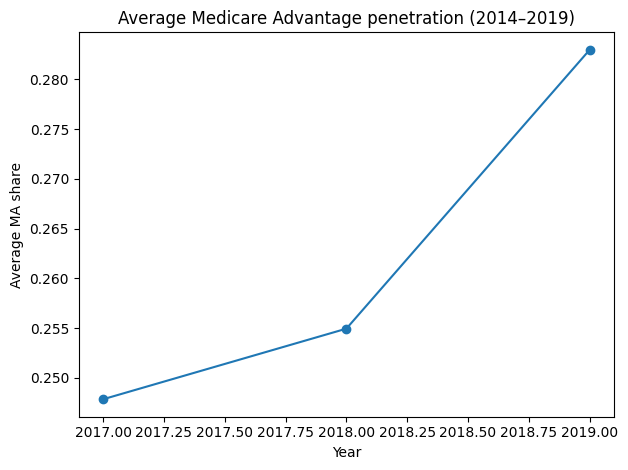

In [10]:
# Question 4 
pen = data.loc[
    data["year"].between(2014, 2019)
    & data["fips"].notna()
    & data["avg_enrolled"].notna()
    & data["avg_eligibles"].notna()
    & (data["avg_eligibles"] > 0),
    ["year", "fips", "avg_enrolled", "avg_eligibles"]
].copy()


pen_county = (
    pen.groupby(["year", "fips"], as_index=False)
       .agg({
           "avg_enrolled": "first",
           "avg_eligibles": "first"
       })
)

# Compute MA share
pen_county["ma_share"] = (
    pen_county["avg_enrolled"] / pen_county["avg_eligibles"]
)

# Average across counties
ma_share_year = (
    pen_county.groupby("year", as_index=False)["ma_share"]
    .mean()
    .rename(columns={"ma_share": "avg_ma_share"})
)

print(ma_share_year)

# Plot
plt.figure()
plt.plot(ma_share_year["year"], ma_share_year["avg_ma_share"], marker="o")
plt.xlabel("Year")
plt.ylabel("Average MA share")
plt.title("Average Medicare Advantage penetration (2014–2019)")
plt.tight_layout()
plt.show()

In [ ]:
# Has Medicare Advantage increased or decreased?
Medicare Advantage has increased and become more popular over time. 

In [11]:
# Question 5
# 1. Keep only 2018 data
data_2018 = data[data["year"] == 2018].copy()

# Ensure numeric types
data_2018["bid"] = pd.to_numeric(data_2018["bid"], errors="coerce")
data_2018["avg_enrollment"] = pd.to_numeric(data_2018["avg_enrollment"], errors="coerce")

# Drop rows with missing values
data_2018 = data_2018.dropna(subset=["bid", "avg_enrollment", "fips"])

# 2. Compute plan market shares within county
data_2018["county_total_enrollment"] = (
    data_2018.groupby("fips")["avg_enrollment"].transform("sum")
)

data_2018["market_share"] = (
    data_2018["avg_enrollment"] / data_2018["county_total_enrollment"]
)

# 3. Compute HHI per county
hhi_2018 = (
    data_2018.groupby("fips")["market_share"]
    .apply(lambda x: (x**2).sum())
    .reset_index(name="hhi")
)

# 4. Determine percentile cutoffs
p33 = hhi_2018["hhi"].quantile(0.33)
p66 = hhi_2018["hhi"].quantile(0.66)

print("33rd percentile HHI:", p33)
print("66th percentile HHI:", p66)

# 5. Classify markets
def classify_market(hhi):
    if hhi <= p33:
        return "competitive"
    elif hhi >= p66:
        return "uncompetitive"
    else:
        return "middle"

hhi_2018["market_type"] = hhi_2018["hhi"].apply(classify_market)

# 6. Merge classification back to plan data
data_2018 = data_2018.merge(hhi_2018, on="fips", how="left")

# 7. Compare average bids
avg_bid = (
    data_2018[data_2018["market_type"].isin(["competitive", "uncompetitive"])]
    .groupby("market_type")["bid"]
    .mean()
    .reset_index()
)

print(avg_bid)

33rd percentile HHI: 0.24384493544805913
66th percentile HHI: 0.426194
     market_type         bid
0    competitive  767.441490
1  uncompetitive  804.567274


In [12]:
print(df.columns)

Index(['contractid', 'planid', 'fips', 'year', 'n_nonmiss', 'avg_enrollment',
       'sd_enrollment', 'min_enrollment', 'max_enrollment', 'first_enrollment',
       'last_enrollment', 'state', 'county', 'org_type', 'plan_type', 'partd',
       'snp', 'eghp', 'org_name', 'org_marketing_name', 'plan_name',
       'parent_org', 'contract_date', 'state_long', 'county_long', 'year_pen',
       'n_elig', 'n_enrol', 'avg_eligibles', 'sd_eligibles', 'min_eligibles',
       'max_eligibles', 'first_eligibles', 'last_eligibles', 'avg_enrolled',
       'sd_enrolled', 'min_enrolled', 'max_enrolled', 'first_enrolled',
       'last_enrolled', 'ssa', 'state_name', 'state_land', 'premium',
       'premium_partc', 'premium_partd_basic', 'premium_partd_supp',
       'premium_partd_total', 'partd_deductible', 'year_land',
       'riskscore_partc', 'payment_partc', 'rebate_partc', 'year_reb',
       'payment_partd', 'directsubsidy_partd', 'reinsurance_partd',
       'costsharing_partd', 'riskscore_partd', 

In [13]:
# Question 6
ffs_col = 'payment_partc'

# 1. Compute quartiles
quartiles = df[ffs_col].quantile([0.25, 0.5, 0.75])
q1, q2, q3 = quartiles[0.25], quartiles[0.5], quartiles[0.75]

# 2. Create quartile indicator variables
df['ffs_q1'] = (df[ffs_col] <= q1).astype(int)
df['ffs_q2'] = ((df[ffs_col] > q1) & (df[ffs_col] <= q2)).astype(int)
df['ffs_q3'] = ((df[ffs_col] > q2) & (df[ffs_col] <= q3)).astype(int)
df['ffs_q4'] = (df[ffs_col] > q3).astype(int)

# 3. Create a dummy treated/control variable
df['treated'] = (df['bid'] > df['bid'].median()).astype(int)

# 4. Average bid by treated/control in each quartile
avg_bids = pd.DataFrame({
    'q1_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q1']==1, 'bid'].mean()),
    'q2_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q2']==1, 'bid'].mean()),
    'q3_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q3']==1, 'bid'].mean()),
    'q4_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q4']==1, 'bid'].mean())
})

# Rename index for clarity
avg_bids = avg_bids.rename(index={0: 'Control', 1: 'Treated'})
print(avg_bids)

/tmp/ipykernel_2396596/1978062469.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'q1_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q1']==1, 'bid'].mean()),
/tmp/ipykernel_2396596/1978062469.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'q2_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q2']==1, 'bid'].mean()),


         q1_avg_bid  q2_avg_bid  q3_avg_bid  q4_avg_bid
treated                                                
Control  638.139236  698.177804  709.032695  709.269978
Treated  860.614011  883.314490  869.661403  884.861507


/tmp/ipykernel_2396596/1978062469.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'q3_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q3']==1, 'bid'].mean()),
/tmp/ipykernel_2396596/1978062469.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'q4_avg_bid': df.groupby('treated').apply(lambda x: x.loc[x['ffs_q4']==1, 'bid'].mean())


In [20]:
# Question 7
# 1. Prepare dataset
df7 = df.copy()

ffs_quartiles = ['ffs_q1','ffs_q2','ffs_q3','ffs_q4']

# Force numeric for these columns (bid, treated, quartile indicators)
numeric_cols = ['bid','treated'] + ffs_quartiles
df7[numeric_cols] = df7[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing numeric data
df7 = df7.dropna(subset=numeric_cols)

# Ensure treated is integer
df7['treated'] = df7['treated'].astype(int)

# Create numeric quartile column
df7['ffs_q'] = df7['ffs_q1']*1 + df7['ffs_q2']*2 + df7['ffs_q3']*3 + df7['ffs_q4']*4
df7['avg_ffscost'] = df7['ffs_q1']*0 + df7['ffs_q2']*0 + df7['ffs_q3']*0 + df7['ffs_q4']*0  # placeholder

# Memory-safe NN matching function
def nn_match_ate_safe(df_in, treat_col, y_col, x_cols, metric="invvar"):
    T = df_in[df_in[treat_col]==1].copy()
    C = df_in[df_in[treat_col]==0].copy()

    Xt = T[x_cols].to_numpy(dtype=float)
    Xc = C[x_cols].to_numpy(dtype=float)

    if metric == "invvar":
        v = np.var(df_in[x_cols].to_numpy(dtype=float), axis=0, ddof=1)
        v = np.where(v==0, 1e-12, v)
        Xt_scaled = Xt / np.sqrt(v)
        Xc_scaled = Xc / np.sqrt(v)
    elif metric == "mahalanobis":
        S = np.cov(df_in[x_cols].to_numpy(dtype=float).T)
        S += np.eye(S.shape[0])*1e-10
        L = np.linalg.cholesky(S)
        Xt_scaled = np.linalg.solve(L, Xt.T).T
        Xc_scaled = np.linalg.solve(L, Xc.T).T
    else:
        raise ValueError("metric must be 'invvar' or 'mahalanobis'")

    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(Xc_scaled)
    _, idx_c_for_t = nn.kneighbors(Xt_scaled)
    nn.fit(Xt_scaled)
    _, idx_t_for_c = nn.kneighbors(Xc_scaled)

    att = (T[y_col].to_numpy(dtype=float) - C.iloc[idx_c_for_t.flatten()][y_col].to_numpy(dtype=float)).mean()
    atu = (T.iloc[idx_t_for_c.flatten()][y_col].to_numpy(dtype=float) - C[y_col].to_numpy(dtype=float)).mean()
    p = df_in[treat_col].mean()
    ate = p*att + (1-p)*atu
    return ate

# NN matching ATEs
ate_nn_invvar = nn_match_ate_safe(df7, "treated", "bid", ffs_quartiles, metric="invvar")
ate_nn_mahal = nn_match_ate_safe(df7, "treated", "bid", ffs_quartiles, metric="mahalanobis")

# IPW
Q = pd.get_dummies(df7['ffs_q'].astype(int), prefix='q', drop_first=True).astype(float)
X_ps = sm.add_constant(Q)
y_ps = df7['treated'].to_numpy(dtype=float)

ps_mod = sm.Logit(y_ps, X_ps).fit(disp=False)
df7['ps'] = ps_mod.predict(X_ps).to_numpy(dtype=float)
df7['ps'] = df7['ps'].clip(1e-6, 1-1e-6)

w_t = df7['treated']/df7['ps']
w_c = (1-df7['treated'])/(1-df7['ps'])

mu1 = np.sum(w_t*df7['bid'].to_numpy(dtype=float)) / np.sum(w_t)
mu0 = np.sum(w_c*df7['bid'].to_numpy(dtype=float)) / np.sum(w_c)
ate_ipw = mu1 - mu0

# linear regression
X_reg = pd.concat([df7[['treated']], Q], axis=1)
for col in Q.columns:
    X_reg[f"treated_x_{col}"] = df7['treated'].to_numpy(dtype=float) * Q[col].to_numpy(dtype=float)

X_reg = sm.add_constant(X_reg, has_constant='add').astype(float)
y_reg = df7['bid'].to_numpy(dtype=float)

reg = sm.OLS(y_reg, X_reg).fit()

beta_t = reg.params['treated']
te = np.full(len(df7), beta_t)
for col in Q.columns:
    te += reg.params.get(f'treated_x_{col}', 0.0) * Q[col].to_numpy(dtype=float)
ate_reg = te.mean()

# results
results_q7 = pd.DataFrame({
    "Estimator":[
        "NN (1-to-1) inverse-variance distance (FFS quartile indicators)",
        "NN (1-to-1) Mahalanobis distance (FFS quartile indicators)",
        "IPW ATE (propensity from FFS quartile dummies)",
        "Linear regression (quartile dummies + interactions; ATE = avg TE)"
    ],
    "ATE (bid)":[
        ate_nn_invvar,
        ate_nn_mahal,
        ate_ipw,
        ate_reg
    ]
})

print(results_q7)

                                           Estimator   ATE (bid)
0  NN (1-to-1) inverse-variance distance (FFS qua...  201.589698
1  NN (1-to-1) Mahalanobis distance (FFS quartile...  173.463197
2     IPW ATE (propensity from FFS quartile dummies)  186.666266
3  Linear regression (quartile dummies + interact...  186.666266


In [ ]:
# Question 8
The results are consistent in their direction (all positive), but they certainly are not identical and their magnitudes depend on 
the estimator. IPW and the linear regression calculated the same ATE, while the NN estimates varied depending on the metric used. 

In [22]:
# Question 9
# Prepare the dataset
df_ipw = df.copy()

# Use actual columns for continuous covariates
cols = ['bid', 'treated', 'payment_partd', 'avg_enrolled']
df_ipw = df_ipw[cols].dropna()

# Force numeric
df_ipw = df_ipw.apply(pd.to_numeric, errors='coerce')
df_ipw = df_ipw.dropna()

# Ensure treated is integer
df_ipw['treated'] = df_ipw['treated'].astype(int)

# -----------------------------
# 2. Fit propensity score model
# -----------------------------
X_ps = sm.add_constant(df_ipw[['payment_partd','avg_enrolled']].astype(float))
y_ps = df_ipw['treated'].astype(float)

ps_mod = sm.Logit(y_ps, X_ps).fit(disp=False)
df_ipw['ps'] = ps_mod.predict(X_ps)

# Clip extreme values
eps = 1e-6
df_ipw['ps'] = df_ipw['ps'].clip(eps, 1-eps)

# -----------------------------
# 3. Compute IPW ATE
# -----------------------------
w_t = df_ipw['treated'] / df_ipw['ps']
w_c = (1 - df_ipw['treated']) / (1 - df_ipw['ps'])

mu1 = np.sum(w_t * df_ipw['bid'].to_numpy(dtype=float)) / np.sum(w_t)
mu0 = np.sum(w_c * df_ipw['bid'].to_numpy(dtype=float)) / np.sum(w_c)

ate_ipw_cont = mu1 - mu0
print("IPW ATE (continuous FFS + total beneficiaries):", ate_ipw_cont)

# -----------------------------
# 4. Compare to quartile-based IPW ATE
# -----------------------------
# Replace with your previous quartile-based IPW ATE
ate_ipw_quart = ate_ipw  # from earlier

comparison = pd.DataFrame({
    'Method': [
        'IPW (quartile FFS indicators)',
        'IPW (continuous FFS + beneficiaries)'
    ],
    'ATE (bid)': [
        ate_ipw_quart,
        ate_ipw_cont
    ]
})

print("\nComparison of IPW ATE estimates:")
print(comparison)

IPW ATE (continuous FFS + total beneficiaries): 161.96527038726606

Comparison of IPW ATE estimates:
                                 Method   ATE (bid)
0         IPW (quartile FFS indicators)  186.666266
1  IPW (continuous FFS + beneficiaries)  161.965270


In [ ]:
# Question 10 
Working with these datasets was very challenging for me initially, especially loading the individual data sets first, creating a 
master document of all of them, and then referencing it in the homework assignment. The most aggravating thing for me was waiting
for the plan enrollments to load. I was also initially confused by how to merge the different aspects of the plans (HHI, service data, 
plan characteristics, etc.) However, analyzing the images and trends of the data was very interesting and showed how complex and 
intricate healthcare data is.
